In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from Bio import SeqIO
from collections import Counter

## Updates
- 04/27 add mask
- 05/31 add true random padding

# Waltz data split

In [2]:
data_dir = '/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data'

In [3]:
path = f'{data_dir}/sbxw_fibrillation_peptide_waltzdb.csv'
waltz_df = pd.read_csv(path,index_col=0)
print(waltz_df.shape)
display(waltz_df.groupby('value_bool').size())
display(waltz_df.groupby(['data_split','value_bool']).size())
print(waltz_df.sequence.nunique())
waltz_df = waltz_df.drop(columns='data_split')
waltz_df['group'] = ''
waltz_df.head()

(1399, 3)


value_bool
False    892
True     507
dtype: int64

data_split  value_bool
test        False         177
            True          100
train       False         715
            True          407
dtype: int64

1399


,sequence,value_bool,group
0,STVPIE,False,
1,GVIWIA,True,
2,LATVYA,False,
3,NATAHQ,False,
4,STVGIE,False,


In [4]:
# shuffle and split into 5 folds
# Section 2.1.1
waltz_df = waltz_df.sample(frac=1,random_state=42).reset_index(drop=True)

# split the dataset into 5 batches
n_batches = 5
n_subset = math.ceil(len(waltz_df)/n_batches)
waltz_df['fold'] = 1+waltz_df.index//n_subset
display(waltz_df.groupby('fold').size())
waltz_df.head()

fold
1    280
2    280
3    280
4    280
5    279
dtype: int64

,sequence,value_bool,group,fold
0,ESNTNN,False,,1
1,RLVFID,False,,1
2,MGNNTV,False,,1
3,GGNSAL,False,,1
4,LVFYQQ,True,,1


In [5]:
# create a new column for each fold
for i in sorted(list(waltz_df.fold.unique())):
    col_name = f'data_split_fold{i}'
    waltz_df[col_name] = waltz_df['fold'].apply(lambda x: 'val' if x == i else 'train')
    print(f'Split: {i}')
    print('Validation indices:',waltz_df[waltz_df[col_name]=='val'].index)
waltz_df.head()

Split: 1
Validation indices: Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279],
      dtype='int64', length=280)
Split: 2
Validation indices: Index([280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       ...
       550, 551, 552, 553, 554, 555, 556, 557, 558, 559],
      dtype='int64', length=280)
Split: 3
Validation indices: Index([560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
       ...
       830, 831, 832, 833, 834, 835, 836, 837, 838, 839],
      dtype='int64', length=280)
Split: 4
Validation indices: Index([ 840,  841,  842,  843,  844,  845,  846,  847,  848,  849,
       ...
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119],
      dtype='int64', length=280)
Split: 5
Validation indices: Index([1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129,
       ...
       1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398],
      dtype='int64', length=279)


,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5
0,ESNTNN,False,,1,val,train,train,train,train
1,RLVFID,False,,1,val,train,train,train,train
2,MGNNTV,False,,1,val,train,train,train,train
3,GGNSAL,False,,1,val,train,train,train,train
4,LVFYQQ,True,,1,val,train,train,train,train


# Serrano data

In [6]:
path = 'tables/serrano_filteredlysozyme.csv' # S2 sequences matching lysozyme are removed
serrano_df = pd.read_csv(path)
serrano_df.dataset = serrano_df.dataset.replace({'cleaned_S1_41587_2004_BFnbt1012_MOESM2_ESM':'serrano_1',
                                                 'cleaned_S2_41587_2004_BFnbt1012_MOESM3_ESM':'serrano_2'})
serrano_df['group'] = serrano_df.dataset
serrano_df['fold'] = -1
serrano_df = serrano_df.drop(columns='dataset')
serrano_df = serrano_df.drop(columns=['Unnamed: 0'])
serrano_df = serrano_df.rename(columns={'exp_aggregation':'value_bool',
                                        'seq':'sequence'})
serrano_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           224 non-null    int64  
 1   parent_protein  224 non-null    object 
 2   name            224 non-null    object 
 3   sequence        224 non-null    object 
 4   value_bool      224 non-null    int64  
 5   tango_pred      224 non-null    int64  
 6   pH              3 non-null      float64
 7   data_split      224 non-null    object 
 8   group           224 non-null    object 
 9   fold            224 non-null    int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 17.6+ KB


In [7]:
serrano_df[serrano_df['parent_protein']=='human lysozyme']

,index,parent_protein,name,sequence,value_bool,tango_pred,pH,data_split,group,fold


In [8]:
s_overlap_df = pd.read_csv('comparison_tables/serrano_vs_waltz_kmers_distance0.csv',index_col=0)
print(s_overlap_df.sequence.nunique())
s_overlap_df

62


,sequence,value_bool,dataset,sequence_length,index,kmer_index,kmer_seq,waltz_index,waltz_seq,distance
7665,PGGGKVQIVYKPV,1,serrano_s1,13,0,5,VQIVYK,670,VQIVYK,0
37407,PGGGKVQIVEKPV,0,serrano_s1,13,3,5,VQIVEK,1033,VQIVEK,0
188136,NLKHQPGGGKVQIVYKPVDLSKVTSKCGSLGNIHHKPGGGQVE,1,serrano_s1,43,8,10,VQIVYK,670,VQIVYK,0
286066,NLKHQPGGGKVQIVYKEVD,1,serrano_s1,19,13,10,VQIVYK,670,VQIVYK,0
356016,GKVQIVYK,1,serrano_s1,8,16,2,VQIVYK,670,VQIVYK,0
...,...,...,...,...,...,...,...,...,...,...
3038541,TEKDEYACRV,0,serrano_s2,10,245,1,EKDEYA,1312,EKDEYA,0
3048328,YACRVNHVTL,0,serrano_s2,10,246,3,RVNHVT,1306,RVNHVT,0
3050741,NHVTLSQPKI,0,serrano_s2,10,247,0,NHVTLS,921,NHVTLS,0
3053268,NHVTLSQPKI,0,serrano_s2,10,247,2,VTLSQP,650,VTLSQP,0


In [9]:
filt_serrano_df = serrano_df[~serrano_df.sequence.isin(s_overlap_df.sequence.unique())]
filt_serrano_df = filt_serrano_df[['sequence','value_bool','parent_protein','name','group','fold']]
filt_serrano_df['seq_aa_length'] = filt_serrano_df['sequence'].apply(lambda x: len(x))
filt_serrano_df = filt_serrano_df[filt_serrano_df['seq_aa_length']>=6]
filt_serrano_df.to_csv('tables/serrano_filteredlysozyme_filteredwaltzoverlap_filteredlt6.csv')
filt_serrano_df

,sequence,value_bool,parent_protein,name,group,fold,seq_aa_length
1,PGGGKVYKPV,0,t-Protein,K19d,serrano_1,-1,10
2,PGGGKNAEVYKPV,0,t-Protein,Mut1,serrano_1,-1,13
4,QTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIVY,0,t-Protein,K19Chym,serrano_1,-1,36
5,KPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDF,0,t-Protein,K19Chym1,serrano_1,-1,36
6,KDRVQSKIGSLDNITHVPGGGN,0,t-Protein,K19Chym2,serrano_1,-1,22
...,...,...,...,...,...,...,...
199,MERVVEQMCI,0,human prion protein,116-125,serrano_2,-1,10
200,EQMCITQYER,0,human prion protein,121-130,serrano_2,-1,10
201,TQYERESQAY,0,human prion protein,126-135,serrano_2,-1,10
202,ESQAYYQRGS,0,human prion protein,131-140,serrano_2,-1,10


In [10]:
# see other notebook
# sns.displot(data=serrano_df,x='n_mutations',y='seq_aa_length',col='group',discrete=True)
# serrano_df.groupby(['group','n_mutations','value_bool']).size()

In [11]:
sorted(x for x in waltz_df.columns if 'data_split_fold' in x)

['data_split_fold1',
 'data_split_fold2',
 'data_split_fold3',
 'data_split_fold4',
 'data_split_fold5']

In [12]:
for col in sorted(x for x in waltz_df.columns if 'data_split_fold' in x):
    filt_serrano_df[col] = 'test'
filt_serrano_df

,sequence,value_bool,parent_protein,name,group,fold,seq_aa_length,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5
1,PGGGKVYKPV,0,t-Protein,K19d,serrano_1,-1,10,test,test,test,test,test
2,PGGGKNAEVYKPV,0,t-Protein,Mut1,serrano_1,-1,13,test,test,test,test,test
4,QTAPVPMPDLKNVKSKIGSTENLKHQPGGGKVQIVY,0,t-Protein,K19Chym,serrano_1,-1,36,test,test,test,test,test
5,KPVDLSKVTSKCGSLGNIHHKPGGGQVEVKSEKLDF,0,t-Protein,K19Chym1,serrano_1,-1,36,test,test,test,test,test
6,KDRVQSKIGSLDNITHVPGGGN,0,t-Protein,K19Chym2,serrano_1,-1,22,test,test,test,test,test
...,...,...,...,...,...,...,...,...,...,...,...,...
199,MERVVEQMCI,0,human prion protein,116-125,serrano_2,-1,10,test,test,test,test,test
200,EQMCITQYER,0,human prion protein,121-130,serrano_2,-1,10,test,test,test,test,test
201,TQYERESQAY,0,human prion protein,126-135,serrano_2,-1,10,test,test,test,test,test
202,ESQAYYQRGS,0,human prion protein,131-140,serrano_2,-1,10,test,test,test,test,test


# Standard dataset

In [13]:
waltz_df.shape

(1399, 9)

In [14]:
concat_df = pd.concat([waltz_df,filt_serrano_df],ignore_index=True)
concat_df.info()
concat_df.to_csv(f'datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test.csv')
concat_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557 entries, 0 to 1556
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sequence          1557 non-null   object 
 1   value_bool        1557 non-null   int64  
 2   group             1557 non-null   object 
 3   fold              1557 non-null   int64  
 4   data_split_fold1  1557 non-null   object 
 5   data_split_fold2  1557 non-null   object 
 6   data_split_fold3  1557 non-null   object 
 7   data_split_fold4  1557 non-null   object 
 8   data_split_fold5  1557 non-null   object 
 9   parent_protein    158 non-null    object 
 10  name              158 non-null    object 
 11  seq_aa_length     158 non-null    float64
dtypes: float64(1), int64(2), object(9)
memory usage: 146.1+ KB


,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length
0,ESNTNN,0,,1,val,train,train,train,train,NaN,NaN,NaN
1,RLVFID,0,,1,val,train,train,train,train,NaN,NaN,NaN
2,MGNNTV,0,,1,val,train,train,train,train,NaN,NaN,NaN
3,GGNSAL,0,,1,val,train,train,train,train,NaN,NaN,NaN
4,LVFYQQ,1,,1,val,train,train,train,train,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1552,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10.0
1553,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10.0
1554,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10.0
1555,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10.0


# AggreProt reimplementation

In [16]:
aggreprot_df = concat_df.copy(deep=True)
aggreprot_df = aggreprot_df[aggreprot_df['fold']!=-1]
temp_waltz_df = waltz_df[waltz_df['fold']==1].copy(deep=True)
temp_waltz_df['data_split_fold1'] = 'test'
temp_waltz_df['data_split_fold2'] = 'test'
temp_waltz_df['data_split_fold3'] = 'test'
temp_waltz_df['data_split_fold4'] = 'test'
temp_waltz_df['data_split_fold5'] = 'test'
aggreprot_df = pd.concat([aggreprot_df,temp_waltz_df],ignore_index=True)
aggreprot_df.to_csv(f'datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_waltzfold1-test_foraggreprot.csv')
aggreprot_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length
0,ESNTNN,0,,1,val,train,train,train,train,NaN,NaN,NaN
1,RLVFID,0,,1,val,train,train,train,train,NaN,NaN,NaN
2,MGNNTV,0,,1,val,train,train,train,train,NaN,NaN,NaN
3,GGNSAL,0,,1,val,train,train,train,train,NaN,NaN,NaN
4,LVFYQQ,1,,1,val,train,train,train,train,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1674,GNNSGP,0,,1,test,test,test,test,test,NaN,NaN,NaN
1675,GMLASR,0,,1,test,test,test,test,test,NaN,NaN,NaN
1676,GYVIIK,1,,1,test,test,test,test,test,NaN,NaN,NaN
1677,GYCFIL,1,,1,test,test,test,test,test,NaN,NaN,NaN


# Padding dataset

Problem: predictors trained on waltzDB dataset sequences, which are all 6 amino acids, can be not be used to classify longer sequences.

Hypothesis: ESM embeddings have a significant length-dependence, e.g. the values in the embedding vectors vary as a function of the length of the sequence. 

Idea: "augment" the sequences in waltzDB by randomly sampling "padding" sequence on the N and C terminus.
- Glycine only, [1-15] residues on either N/C-terminus, 30 residues on either terminus total
- Non-hydrophobic residues (not A,V,I,L,M,W,Y,F), same length distribution

Add serrano s1 sequences, padding if < 30 amino acids to create combined dataset for training

Use serrano s2 sequences for testing and original waltz sequences for testing

# AA distributions

In [91]:
all_aa = ['R','H','K',
          'D','E',
          'S','T','N','Q',
          'C','G','P',
          'A','V','I','L','M','F','Y','W']

aa_dist = {
    'Waltz':Counter(''.join(waltz_df['sequence'])),
    'Waltz positive':Counter(''.join(waltz_df[waltz_df['value_bool']==True]['sequence'])),
    'Waltz negative':Counter(''.join(waltz_df[waltz_df['value_bool']==False]['sequence'])),
}
aa_df = pd.DataFrame(aa_dist)

aa_df['Non-hydrophobic'] = 0
for aa in 'CDEGHKNPQRST':
    aa_df.loc[aa,'Non-hydrophobic'] = 1
for aa in all_aa:
    aa_df.loc[aa,'Random'] = 1
for col in aa_df.columns:
    aa_df[col]/=aa_df[col].sum()
aa_df = aa_df.reindex(all_aa)
aa_df = aa_df.reset_index(names='aa')
aa_df

,aa,Waltz,Waltz positive,Waltz negative,Non-hydrophobic,Random
0,R,0.013581,0.004931,0.018498,0.083333,0.05
1,H,0.012985,0.014793,0.011958,0.083333,0.05
2,K,0.042411,0.037475,0.045217,0.083333,0.05
3,D,0.019657,0.010191,0.025037,0.083333,0.05
4,E,0.043841,0.033531,0.049701,0.083333,0.05
5,S,0.073386,0.050953,0.086136,0.083333,0.05
6,T,0.072671,0.076266,0.070628,0.083333,0.05
7,N,0.094949,0.049310,0.120889,0.083333,0.05
8,Q,0.077436,0.058514,0.088191,0.083333,0.05
9,C,0.007982,0.014464,0.004297,0.083333,0.05


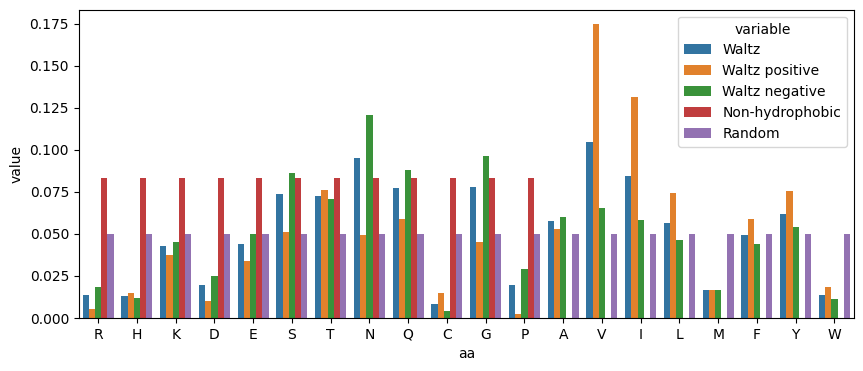

In [100]:
plt.figure(figsize=(10,4))
sns.barplot(data=aa_df.melt(id_vars='aa',value_vars=['Waltz','Waltz positive','Waltz negative','Non-hydrophobic','Random']),
            x='aa',y='value',hue='variable')
plt.savefig('plots/250407_aadistribution_waltz.png',dpi=300)
plt.savefig('plots/250407_aadistribution_waltz.pdf',dpi=300)

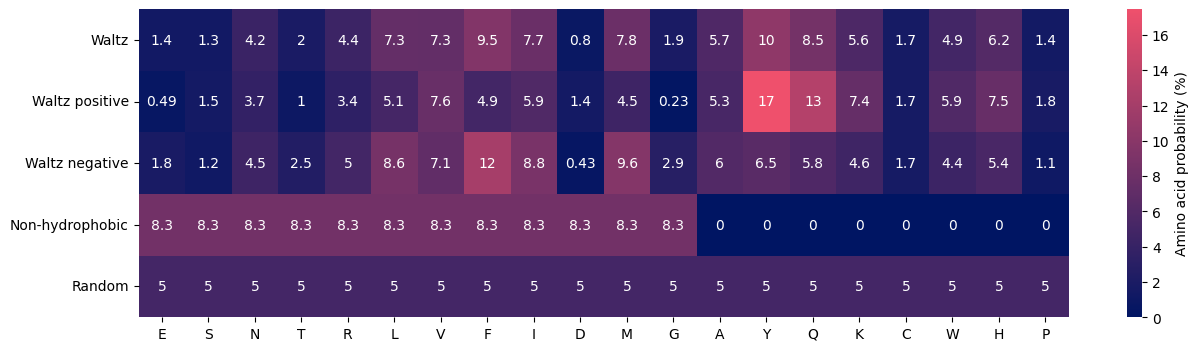

In [127]:
# aa_df_t = aa_df.drop(columns='Random').transpose()
aa_df_t = aa_df.transpose()
aa_df_t = aa_df_t.rename(columns=temp.loc['aa'])
aa_df_t = aa_df_t.drop(index='aa')

# Define the two hex colors (peachpear)
# "Passionfruit" : ["#C00077", "#EF506C", "#9FB800", "#009A90", "#0054A4", "#001563","#F5FFFF"],
hex_color1 = "#001563"  # Example: a shade of red
hex_color2 = "#EF506C"  # Example: a shade of blue
# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [hex_color1, hex_color2])

plt.figure(figsize=(15,4))
ax = sns.heatmap(data=aa_df_t.to_numpy(dtype=float)*100,
            xticklabels=aa_df_t.columns,
            yticklabels=aa_df_t.index,
            cbar_kws={'label':'Amino acid probability (%)'},
            annot=True,
            cmap=cmap)
plt.savefig('plots/250531_aadistribution_waltz_heatmap.png',dpi=300)
plt.savefig('plots/250531_aadistribution_waltz_heatmap.pdf',dpi=300)

# Defining functions

In [72]:
def sampleString(
    charSet,
    length
):
    return ''.join([random.choice(charSet) for _ in range(length)])

def padSequence(
    sequence:str,
    terminal_residue_id:str='gly', #or non-hydrophobic
    n_terminal_residues:int=15 #inclusive
):
    
    gly = 'G'
    nonhydrophobic = 'CDEGHKNPQRST'
    x_token = 'X'
    
    n_res_nterm = random.randint(1,n_terminal_residues)
    n_res_cterm = random.randint(1,n_terminal_residues)

    if terminal_residue_id == 'gly':
        padded_seq = sampleString(gly,n_res_nterm)+sequence+sampleString(gly,n_res_cterm)
    elif terminal_residue_id == 'non-hydrophobic':
        padded_seq = sampleString(nonhydrophobic,n_res_nterm)+sequence+sampleString(nonhydrophobic,n_res_cterm)
    elif terminal_residue_id == 'x_token':
        padded_seq = sampleString(x_token,n_res_nterm)+sequence+sampleString(x_token,n_res_cterm)
    else:
        raise ValueError(f"terminal_residue_id == {terminal_residue_id} not recognized")

    mask = ''.join([str(0)]*n_res_nterm+[str(1)]*len(sequence)+[str(0)]*n_res_cterm)
    return padded_seq,mask

def pad_sequence_probdist(
    sequence:str,
    amino_acids:list[str],
    aa_prod_dist:np.ndarray,
    n_terminal_residues:int=15 #inclusive
):
    n_res_nterm = np.random.randint(1,n_terminal_residues)
    n_res_cterm = np.random.randint(1,n_terminal_residues)
    
    nterminal_seq = ''.join(np.random.choice(amino_acids, n_res_nterm,p=aa_prod_dist))
    cterminal_seq = ''.join(np.random.choice(amino_acids, n_res_cterm,p=aa_prod_dist))
    padded_seq = nterminal_seq + sequence + cterminal_seq

    mask = ''.join(([str(0)]*n_res_nterm)+([str(1)]*len(sequence))+([str(0)]*n_res_cterm))
    return padded_seq,mask

random.seed(42)

print(padSequence('STVPIE','gly'))
print(padSequence('STVPIE','non-hydrophobic'))
print(pad_sequence_probdist('STVPIE',list(aa_df['aa']),np.array(aa_df['Waltz negative']),10))

('GGGGGGGGGGGSTVPIEGG', '0000000000011111100')
('CQGTSTQNGSTVPIEPRHCETNKHE', '0000000001111110000000000')
('PASESVASTVPIEGE', '000000011111100')


In [73]:
comb_df = pd.read_csv(f'datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test.csv',index_col=0)
comb_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length
0,ESNTNN,0,NaN,1,val,train,train,train,train,NaN,NaN,NaN
1,RLVFID,0,NaN,1,val,train,train,train,train,NaN,NaN,NaN
2,MGNNTV,0,NaN,1,val,train,train,train,train,NaN,NaN,NaN
3,GGNSAL,0,NaN,1,val,train,train,train,train,NaN,NaN,NaN
4,LVFYQQ,1,NaN,1,val,train,train,train,train,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1552,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10.0
1553,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10.0
1554,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10.0
1555,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10.0


In [74]:
def plot_aa_dist(df):
    aa_dist = {
        'overall':Counter(''.join(df['sequence'])),
    }
    aa_df = pd.DataFrame(aa_dist)
    
    aa_df['randpad'] = 0
    for aa in 'CDEGHKNPQRST':
        aa_df.loc[aa,'randpad'] = 1
    for col in aa_df.columns:
        aa_df[col]/=aa_df[col].sum()
    aa_df = aa_df.reset_index(names='aa')
    aa_df = aa_df.sort_values(by='aa')
    plt.figure(figsize=(10,4))
    sns.barplot(data=aa_df.melt(id_vars='aa',value_vars=['overall','randpad']),
                x='aa',y='value',hue='variable')

# Randpad

## Rand-padded, 10X (pad 10)

In [60]:
pad_max_len = 10
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['fold'] == -1: # test sequences are not padded
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'non-hydrophobic',pad_max_len)
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['seq_aa_length'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length,mask,core_sequence
0,THESNTNNG,0,NaN,1,val,train,train,train,train,NaN,NaN,9,001111110,ESNTNN
1,TDSTESNTNNQDR,0,NaN,1,val,train,train,train,train,NaN,NaN,13,0000111111000,ESNTNN
2,CDGGQRCESNTNNQ,0,NaN,1,val,train,train,train,train,NaN,NaN,14,00000001111110,ESNTNN
3,NGPRESNTNNHCETNKHEG,0,NaN,1,val,train,train,train,train,NaN,NaN,19,0000111111000000000,ESNTNN
4,DNDKKRESNTNNHC,0,NaN,1,val,train,train,train,train,NaN,NaN,14,00000011111100,ESNTNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14143,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10,1111111111,MERVVEQMCI
14144,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10,1111111111,EQMCITQYER
14145,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10,1111111111,TQYERESQAY
14146,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10,1111111111,ESQAYYQRGS


In [61]:
# check some basic things about it
display(rand_padded_waltz_df.groupby('fold').sequence.nunique())
display(rand_padded_waltz_df.groupby('fold').core_sequence.nunique())

fold
-1     157
 1    2800
 2    2800
 3    2800
 4    2800
 5    2790
Name: sequence, dtype: int64

fold
-1    157
 1    280
 2    280
 3    280
 4    280
 5    279
Name: core_sequence, dtype: int64

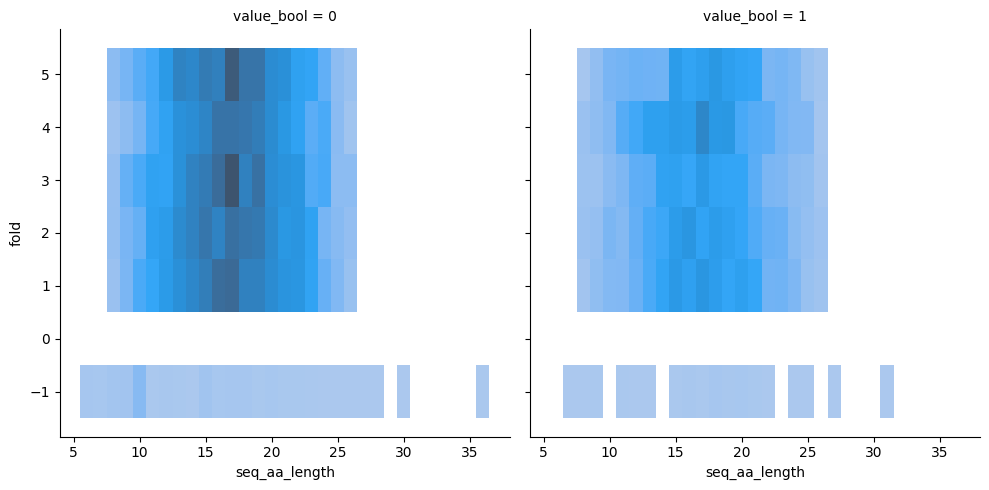

In [62]:
sns.displot(rand_padded_waltz_df,
             x='seq_aa_length',
             col='value_bool',
             y='fold',discrete=True)

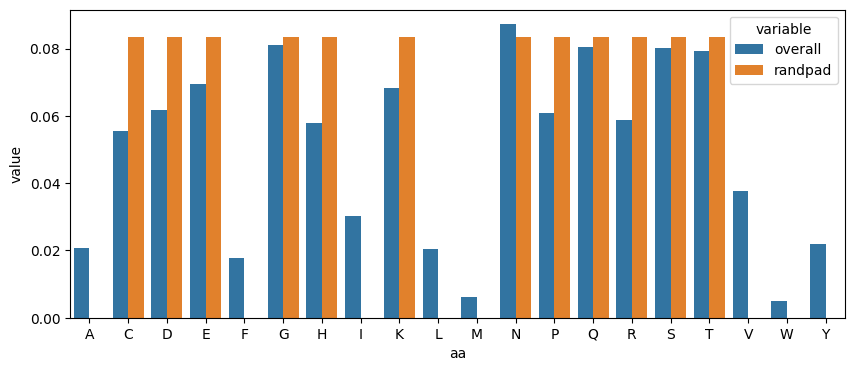

In [63]:
plot_aa_dist(rand_padded_waltz_df)

## Rand-padded, 10X (pad 5)

In [28]:
pad_max_len = 5
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['fold'] == -1: # test data
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'non-hydrophobic',pad_max_len)
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['seq_aa_length'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length,mask,core_sequence
0,TESNTNNH,0,NaN,1,val,train,train,train,train,NaN,NaN,8,01111110,ESNTNN
1,ETESNTNNDS,0,NaN,1,val,train,train,train,train,NaN,NaN,10,0011111100,ESNTNN
2,RNCCDESNTNNG,0,NaN,1,val,train,train,train,train,NaN,NaN,12,000001111110,ESNTNN
3,RCESNTNNQGTST,0,NaN,1,val,train,train,train,train,NaN,NaN,13,0011111100000,ESNTNN
4,GPRHCESNTNNETNK,0,NaN,1,val,train,train,train,train,NaN,NaN,15,000001111110000,ESNTNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14143,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10,1111111111,MERVVEQMCI
14144,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10,1111111111,EQMCITQYER
14145,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10,1111111111,TQYERESQAY
14146,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10,1111111111,ESQAYYQRGS


In [29]:
# check some basic things about it
display(rand_padded_waltz_df.groupby('fold').sequence.nunique())
display(rand_padded_waltz_df.groupby('fold').core_sequence.nunique())

fold
-1     157
 1    2800
 2    2800
 3    2800
 4    2800
 5    2790
Name: sequence, dtype: int64

fold
-1    157
 1    280
 2    280
 3    280
 4    280
 5    279
Name: core_sequence, dtype: int64

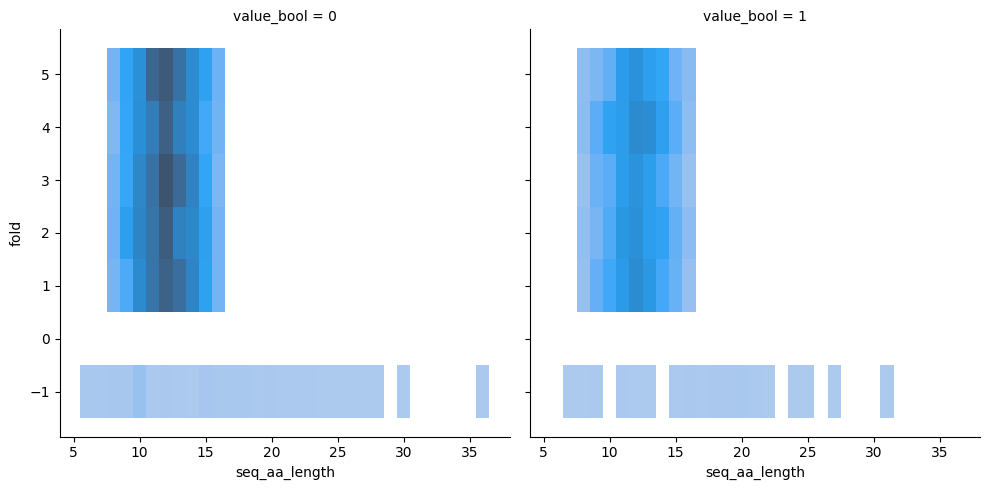

In [30]:
sns.displot(rand_padded_waltz_df,
             x='seq_aa_length',
             col='value_bool',
             y='fold',discrete=True)

## Rand-padded, 10X (pad 20)

In [31]:
pad_max_len = 20
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['fold'] == -1:
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'non-hydrophobic',pad_max_len)
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['seq_aa_length'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length,mask,core_sequence
0,THGGESNTNNE,0,NaN,1,val,train,train,train,train,NaN,NaN,11,00001111110,ESNTNN
1,DRNCESNTNNCDGGQRCQGTSTQNGPRH,0,NaN,1,val,train,train,train,train,NaN,NaN,28,0000111111000000000000000000,ESNTNN
2,TESNTNNNKHEGK,0,NaN,1,val,train,train,train,train,NaN,NaN,13,0111111000000,ESNTNN
3,NDKKESNTNNRHC,0,NaN,1,val,train,train,train,train,NaN,NaN,13,0000111111000,ESNTNN
4,DNDQHSRKRGTDCSGESNTNNHDGDNHPSKEKKGSHTSS,0,NaN,1,val,train,train,train,train,NaN,NaN,39,000000000000000111111000000000000000000,ESNTNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14143,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10,1111111111,MERVVEQMCI
14144,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10,1111111111,EQMCITQYER
14145,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10,1111111111,TQYERESQAY
14146,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10,1111111111,ESQAYYQRGS


In [32]:
# check some basic things about it
display(rand_padded_waltz_df.groupby('fold').sequence.nunique())
display(rand_padded_waltz_df.groupby('fold').core_sequence.nunique())

fold
-1     157
 1    2800
 2    2800
 3    2800
 4    2800
 5    2790
Name: sequence, dtype: int64

fold
-1    157
 1    280
 2    280
 3    280
 4    280
 5    279
Name: core_sequence, dtype: int64

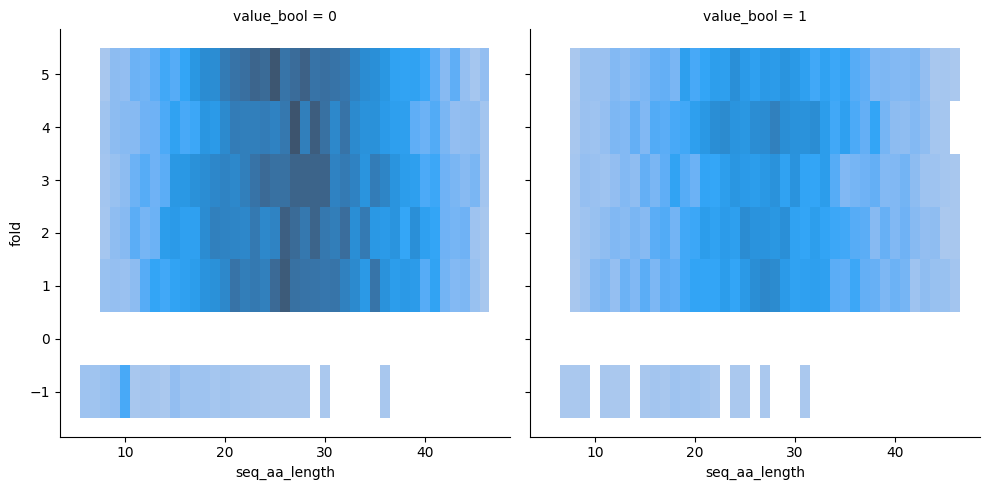

In [33]:
sns.displot(rand_padded_waltz_df,
             x='seq_aa_length',
             col='value_bool',
             y='fold',discrete=True)

# AA distribution padding

## Waltz-negative padded, 10X (pad 10)

In [64]:
pad_max_len = 10
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['fold'] == -1:
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] =  pad_sequence_probdist(row.sequence,list(aa_df['aa']),np.array(aa_df['Waltz negative']),pad_max_len)
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['seq_aa_length'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_waltznegativeaapadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length,mask,core_sequence
0,NNGESNTNNADTVT,0,NaN,1,val,train,train,train,train,NaN,NaN,14,00011111100000,NaN
1,NPVTESNTNNGGPGE,0,NaN,1,val,train,train,train,train,NaN,NaN,15,000011111100000,NaN
2,GPTKVQAGESNTNNRKQNGAYVG,0,NaN,1,val,train,train,train,train,NaN,NaN,23,00000000111111000000000,NaN
3,NASESNTNNESPYLL,0,NaN,1,val,train,train,train,train,NaN,NaN,15,000111111000000,NaN
4,KGEENESNTNNGQPIISVNA,0,NaN,1,val,train,train,train,train,NaN,NaN,20,00000111111000000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14143,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10,1111111111,MERVVEQMCI
14144,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10,1111111111,EQMCITQYER
14145,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10,1111111111,TQYERESQAY
14146,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10,1111111111,ESQAYYQRGS


In [65]:
# check some basic things about it
display(rand_padded_waltz_df.groupby('fold').sequence.nunique())
display(rand_padded_waltz_df.groupby('fold').core_sequence.nunique())

fold
-1     157
 1    2800
 2    2800
 3    2800
 4    2800
 5    2790
Name: sequence, dtype: int64

fold
-1    157
 1      0
 2      0
 3      0
 4      0
 5      0
Name: core_sequence, dtype: int64

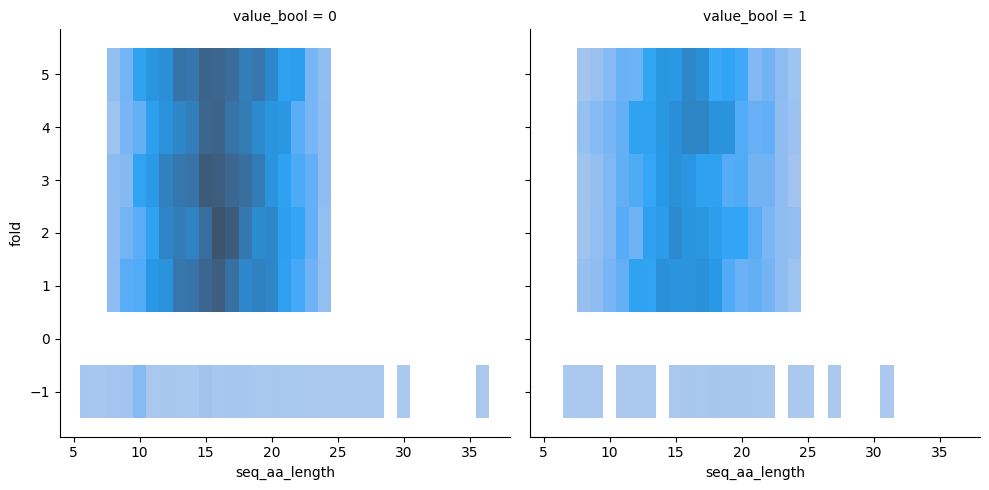

In [66]:
sns.displot(rand_padded_waltz_df,
             x='seq_aa_length',
             col='value_bool',
             y='fold',discrete=True)

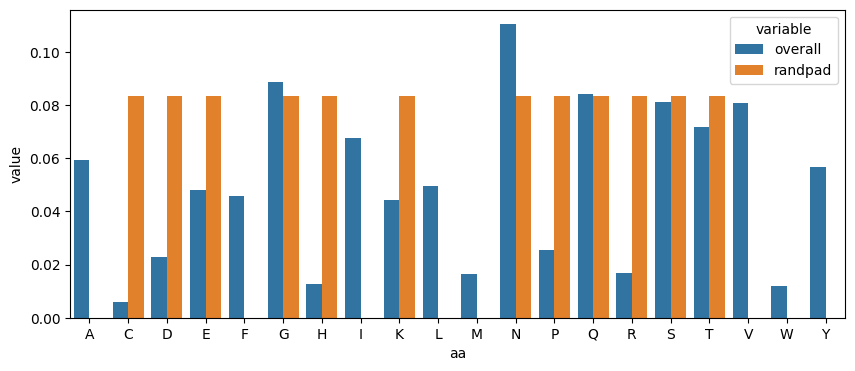

In [67]:
plot_aa_dist(rand_padded_waltz_df)

# Mask-padded

## Rand-padded, 10X (pad 10)

In [22]:
pad_max_len = 10
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['fold'] == -1: # test sequences are not padded
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] = padSequence(row.sequence,'x_token',pad_max_len)
            row_dict['core_sequence'] = row['sequence']
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['seq_aa_length'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_xpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length,mask,core_sequence
0,XXESNTNNX,0,NaN,1,val,train,train,train,train,NaN,NaN,9,001111110,ESNTNN
1,XXXESNTNNXX,0,NaN,1,val,train,train,train,train,NaN,NaN,11,00011111100,ESNTNN
2,XXXXESNTNNXXXX,0,NaN,1,val,train,train,train,train,NaN,NaN,14,00001111110000,ESNTNN
3,XXXXXXXESNTNNXXXXXX,0,NaN,1,val,train,train,train,train,NaN,NaN,19,0000000111111000000,ESNTNN
4,XXXXXXXXXESNTNNXX,0,NaN,1,val,train,train,train,train,NaN,NaN,17,00000000011111100,ESNTNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14143,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10,1111111111,MERVVEQMCI
14144,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10,1111111111,EQMCITQYER
14145,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10,1111111111,TQYERESQAY
14146,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10,1111111111,ESQAYYQRGS


In [23]:
# check some basic things about it
display(rand_padded_waltz_df.groupby('fold').sequence.nunique())
display(rand_padded_waltz_df.groupby('fold').core_sequence.nunique())

fold
-1     157
 1    2673
 2    2701
 3    2680
 4    2664
 5    2678
Name: sequence, dtype: int64

fold
-1    157
 1    280
 2    280
 3    280
 4    280
 5    279
Name: core_sequence, dtype: int64

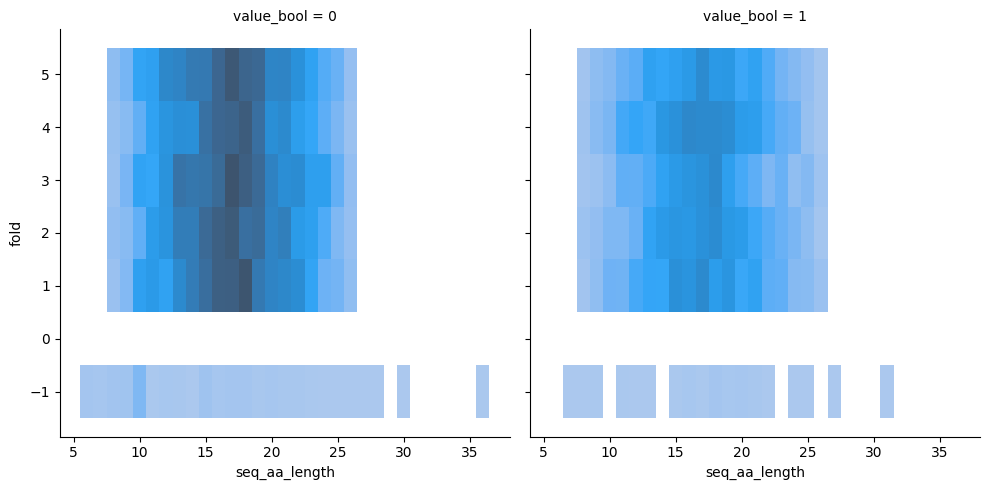

In [24]:
sns.displot(rand_padded_waltz_df,
             x='seq_aa_length',
             col='value_bool',
             y='fold',discrete=True)

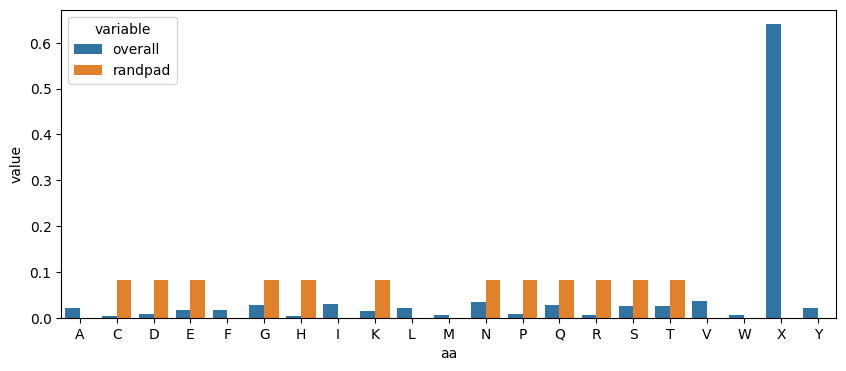

In [25]:
plot_aa_dist(rand_padded_waltz_df)

# (true) Random-padded

## Rand-padded, 10X (pad 10)

In [76]:
pad_max_len = 10
coverage = 10
random.seed(42)
data = list()
for i,row in comb_df.iterrows():
    if row['fold'] == -1:
        row_dict = dict(row)
        row_dict['mask'] = ''.join(['1']*len(row['sequence']))
        row_dict['core_sequence'] = row['sequence']
        data.append(row_dict)
    else:
        for j in range(coverage):
            row_dict = dict(row)
            row_dict['sequence'],row_dict['mask'] =  pad_sequence_probdist(row.sequence,list(aa_df['aa']),np.array(aa_df['Random']),pad_max_len)
            data.append(row_dict)
rand_padded_waltz_df = pd.DataFrame(data)
rand_padded_waltz_df['seq_aa_length'] = rand_padded_waltz_df['sequence'].apply(len)
rand_padded_waltz_df.to_csv(f"datasets/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_TRUErandpadded10x_padlen-{pad_max_len}.csv")
rand_padded_waltz_df

,sequence,value_bool,group,fold,data_split_fold1,data_split_fold2,data_split_fold3,data_split_fold4,data_split_fold5,parent_protein,name,seq_aa_length,mask,core_sequence
0,NYREMEMKLESNTNNEDG,0,NaN,1,val,train,train,train,train,NaN,NaN,18,000000000111111000,NaN
1,MMETVESNTNNVF,0,NaN,1,val,train,train,train,train,NaN,NaN,13,0000011111100,NaN
2,SHHESNTNNVWS,0,NaN,1,val,train,train,train,train,NaN,NaN,12,000111111000,NaN
3,GSLALWESNTNNDYL,0,NaN,1,val,train,train,train,train,NaN,NaN,15,000000111111000,NaN
4,KESNTNNWCGPKYKMS,0,NaN,1,val,train,train,train,train,NaN,NaN,16,0111111000000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14143,MERVVEQMCI,0,serrano_2,-1,test,test,test,test,test,human prion protein,116-125,10,1111111111,MERVVEQMCI
14144,EQMCITQYER,0,serrano_2,-1,test,test,test,test,test,human prion protein,121-130,10,1111111111,EQMCITQYER
14145,TQYERESQAY,0,serrano_2,-1,test,test,test,test,test,human prion protein,126-135,10,1111111111,TQYERESQAY
14146,ESQAYYQRGS,0,serrano_2,-1,test,test,test,test,test,human prion protein,131-140,10,1111111111,ESQAYYQRGS


In [78]:
# check some basic things about it
display(rand_padded_waltz_df.groupby('fold').sequence.nunique())
display(rand_padded_waltz_df.groupby('fold').core_sequence.nunique())

fold
-1     157
 1    2800
 2    2800
 3    2800
 4    2800
 5    2790
Name: sequence, dtype: int64

fold
-1    157
 1      0
 2      0
 3      0
 4      0
 5      0
Name: core_sequence, dtype: int64

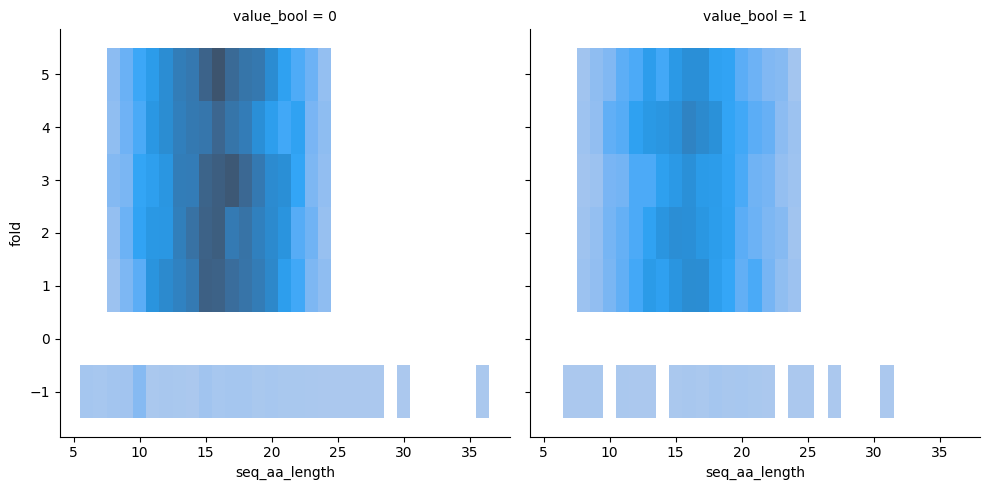

In [79]:
sns.displot(rand_padded_waltz_df,
             x='seq_aa_length',
             col='value_bool',
             y='fold',discrete=True)

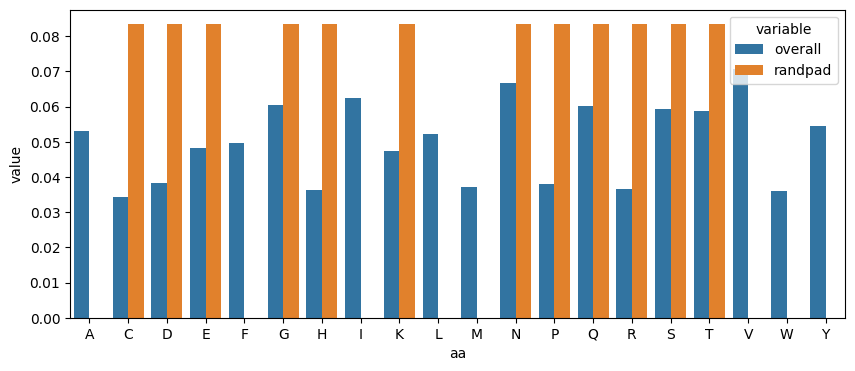

In [80]:
plot_aa_dist(rand_padded_waltz_df)